In [1]:
!pip install wget
import wget
import torch
import tqdm
import os
import typing
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
import cv2

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c76d4b7c8cc73bc3381c8c7c3195d605cfe8aaf3fe95b74c7ac6090e402185b9
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [21]:

def loadvideo(filename: str) -> np.ndarray:
    if not os.path.exists(filename):
        raise FileNotFoundError(filename)
    capture = cv2.VideoCapture(filename)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    v = np.zeros((frame_count, frame_height, frame_width, 3), np.uint8)
    for count in range(frame_count):
        ret, frame = capture.read()
        if not ret:
            raise ValueError("Failed to load frame #{} of {}.".format(count, filename))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        v[count, :, :] = frame
    v = v.transpose((3, 0, 1, 2))
    return v


def savevideo(filename: str, array: np.ndarray, fps: typing.Union[float, int] = 1):
    c, _, height, width = array.shape
    if c != 3:
        raise ValueError("savevideo expects array of shape (channels=3, frames, height, width), got shape ({})".format(", ".join(map(str, array.shape))))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height))
    for frame in array.transpose((1, 2, 3, 0)):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)




def bootstrap(a, b, func, samples=10000):
    a = np.array(a)
    b = np.array(b)
    bootstraps = []
    for _ in range(samples):
        ind = np.random.choice(len(a), len(a))
        bootstraps.append(func(a[ind], b[ind]))
    bootstraps = sorted(bootstraps)
    return func(a, b), bootstraps[round(0.05 * len(bootstraps))], bootstraps[round(0.95 * len(bootstraps))]


def latexify():
    params = {'backend': 'pdf',
              'axes.titlesize': 8,
              'axes.labelsize': 8,
              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'font.family': 'DejaVu Serif',
              'font.serif': 'Computer Modern',
              }
    matplotlib.rcParams.update(params)


def dice_similarity_coefficient(inter, union):
    return 2 * sum(inter) / (sum(union) + sum(inter))
"""EchoNet-Dynamic Dataset."""

import os
import collections
import pandas

import numpy as np
import skimage.draw
import torchvision



class Echo(torchvision.datasets.VisionDataset):

    def __init__(self, root=None,
                 split="train", target_type="EF",
                 mean=0., std=1.,
                 length=16, period=2,
                 max_length=250,
                 clips=1,
                 pad=None,
                 noise=None,
                 target_transform=None,
                 external_test_location=None):
        if root is None:
            root = "/content/EchoNet-Dynamic"

        super().__init__(root, target_transform=target_transform)

        self.split = split.upper()
        if not isinstance(target_type, list):
            target_type = [target_type]
        self.target_type = target_type
        self.mean = mean
        self.std = std
        self.length = length
        self.max_length = max_length
        self.period = period
        self.clips = clips
        self.pad = pad
        self.noise = noise
        self.target_transform = target_transform
        self.external_test_location = external_test_location

        self.fnames, self.outcome = [], []

        if self.split == "EXTERNAL_TEST":
            self.fnames = sorted(os.listdir(self.external_test_location))
        else:
            # Load video-level labels
            with open(os.path.join(self.root, "FileList.csv")) as f:
                data = pandas.read_csv(f)
            data["Split"].map(lambda x: x.upper())

            if self.split != "ALL":
                data = data[data["Split"] == self.split]

            self.header = data.columns.tolist()
            self.fnames = data["FileName"].tolist()
            self.fnames = [fn + ".avi" for fn in self.fnames if os.path.splitext(fn)[1] == ""]  # Assume avi if no suffix
            self.outcome = data.values.tolist()

            # Check that files are present
            missing = set(self.fnames) - set(os.listdir(os.path.join(self.root, "Videos")))
            if len(missing) != 0:
                print("{} videos could not be found in {}:".format(len(missing), os.path.join(self.root, "Videos")))
                for f in sorted(missing):
                    print("\t", f)
                raise FileNotFoundError(os.path.join(self.root, "Videos", sorted(missing)[0]))

            # Load traces
            self.frames = collections.defaultdict(list)
            self.trace = collections.defaultdict(_defaultdict_of_lists)

            with open(os.path.join(self.root, "VolumeTracings.csv")) as f:
                header = f.readline().strip().split(",")
                assert header == ["FileName", "X1", "Y1", "X2", "Y2", "Frame"]

                for line in f:
                    filename, x1, y1, x2, y2, frame = line.strip().split(',')
                    x1 = float(x1)
                    y1 = float(y1)
                    x2 = float(x2)
                    y2 = float(y2)
                    frame = int(frame)
                    if frame not in self.trace[filename]:
                        self.frames[filename].append(frame)
                    self.trace[filename][frame].append((x1, y1, x2, y2))
            for filename in self.frames:
                for frame in self.frames[filename]:
                    self.trace[filename][frame] = np.array(self.trace[filename][frame])

            # A small number of videos are missing traces; remove these videos
            keep = [len(self.frames[f]) >= 2 for f in self.fnames]
            self.fnames = [f for (f, k) in zip(self.fnames, keep) if k]
            self.outcome = [f for (f, k) in zip(self.outcome, keep) if k]

    def __getitem__(self, index):
        # Find filename of video
        if self.split == "EXTERNAL_TEST":
            video = os.path.join(self.external_test_location, self.fnames[index])
        elif self.split == "CLINICAL_TEST":
            video = os.path.join(self.root, "ProcessedStrainStudyA4c", self.fnames[index])
        else:
            video = os.path.join(self.root, "Videos", self.fnames[index])

        # Load video into np.array
        video = loadvideo(video).astype(np.float32)

        # Add simulated noise (black out random pixels)
        # 0 represents black at this point (video has not been normalized yet)
        if self.noise is not None:
            n = video.shape[1] * video.shape[2] * video.shape[3]
            ind = np.random.choice(n, round(self.noise * n), replace=False)
            f = ind % video.shape[1]
            ind //= video.shape[1]
            i = ind % video.shape[2]
            ind //= video.shape[2]
            j = ind
            video[:, f, i, j] = 0

        # Apply normalization
        if isinstance(self.mean, (float, int)):
            video -= self.mean
        else:
            video -= self.mean.reshape(3, 1, 1, 1)

        if isinstance(self.std, (float, int)):
            video /= self.std
        else:
            video /= self.std.reshape(3, 1, 1, 1)

        # Set number of frames
        c, f, h, w = video.shape
        if self.length is None:
            # Take as many frames as possible
            length = f // self.period
        else:
            # Take specified number of frames
            length = self.length

        if self.max_length is not None:
            # Shorten videos to max_length
            length = min(length, self.max_length)

        if f < length * self.period:
            # Pad video with frames filled with zeros if too short
            # 0 represents the mean color (dark grey), since this is after normalization
            video = np.concatenate((video, np.zeros((c, length * self.period - f, h, w), video.dtype)), axis=1)
            c, f, h, w = video.shape  # pylint: disable=E0633

        if self.clips == "all":
            # Take all possible clips of desired length
            start = np.arange(f - (length - 1) * self.period)
        else:
            # Take random clips from video
            start = np.random.choice(f - (length - 1) * self.period, self.clips)

        # Gather targets
        target = []
        for t in self.target_type:
            key = self.fnames[index]
            if t == "Filename":
                target.append(self.fnames[index])
            elif t == "LargeIndex":
                # Traces are sorted by cross-sectional area
                # Largest (diastolic) frame is last
                target.append(np.int(self.frames[key][-1]))
            elif t == "SmallIndex":
                # Largest (diastolic) frame is first
                target.append(np.int(self.frames[key][0]))
            elif t == "LargeFrame":
                target.append(video[:, self.frames[key][-1], :, :])
            elif t == "SmallFrame":
                target.append(video[:, self.frames[key][0], :, :])
            elif t in ["LargeTrace", "SmallTrace"]:
                if t == "LargeTrace":
                    t = self.trace[key][self.frames[key][-1]]
                else:
                    t = self.trace[key][self.frames[key][0]]
                x1, y1, x2, y2 = t[:, 0], t[:, 1], t[:, 2], t[:, 3]
                x = np.concatenate((x1[1:], np.flip(x2[1:])))
                y = np.concatenate((y1[1:], np.flip(y2[1:])))

                r, c = skimage.draw.polygon(np.rint(y).astype(np.int64), np.rint(x).astype(np.int64), (video.shape[2], video.shape[3]))
                mask = np.zeros((video.shape[2], video.shape[3]), np.float32)
                mask[r, c] = 1
                target.append(mask)
            else:
                if self.split == "CLINICAL_TEST" or self.split == "EXTERNAL_TEST":
                    target.append(np.float32(0))
                else:
                    target.append(np.float32(self.outcome[index][self.header.index(t)]))

        if target != []:
            target = tuple(target) if len(target) > 1 else target[0]
            if self.target_transform is not None:
                target = self.target_transform(target)

        # Select clips from video
        video = tuple(video[:, s + self.period * np.arange(length), :, :] for s in start)
        if self.clips == 1:
            video = video[0]
        else:
            video = np.stack(video)

        if self.pad is not None:
            # Add padding of zeros (mean color of videos)
            # Crop of original size is taken out
            # (Used as augmentation)
            c, l, h, w = video.shape
            temp = np.zeros((c, l, h + 2 * self.pad, w + 2 * self.pad), dtype=video.dtype)
            temp[:, :, self.pad:-self.pad, self.pad:-self.pad] = video  # pylint: disable=E1130
            i, j = np.random.randint(0, 2 * self.pad, 2)
            video = temp[:, :, i:(i + h), j:(j + w)]

        return video, target

    def __len__(self):
        return len(self.fnames)

    def extra_repr(self) -> str:
        lines = ["Target type: {target_type}", "Split: {split}"]
        return '\n'.join(lines).format(**self.__dict__)


def _defaultdict_of_lists():
    return collections.defaultdict(list)





def get_mean_and_std(dataset: torch.utils.data.Dataset,
                     samples: int = 128,
                     batch_size: int = 8,
                     num_workers: int = 4):


    if samples is not None and len(dataset) > samples:
        indices = np.random.choice(len(dataset), samples, replace=False)
        dataset = torch.utils.data.Subset(dataset, indices)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    n = 0
    s1 = 0.
    s2 = 0.
    for (x, *_) in tqdm.tqdm(dataloader):
        x = x.transpose(0, 1).contiguous().view(3, -1)
        n += x.shape[1]
        s1 += torch.sum(x, dim=1).numpy()
        s2 += torch.sum(x ** 2, dim=1).numpy()
    mean = s1 / n  # type: np.ndarray
    std = np.sqrt(s2 / n - mean ** 2)  # type: np.ndarray

    mean = mean.astype(np.float32)
    std = std.astype(np.float32)

    return mean, std

def ef_run_epoch(model, dataloader, train, optim, device, save_all=False, block_size=None):


    model.train(train)

    total = 0  # total training loss
    n = 0      # number of videos processed
    s1 = 0     # sum of ground truth EF
    s2 = 0     # Sum of ground truth EF squared

    yhat = []
    y = []

    with torch.set_grad_enabled(train):
        with tqdm.tqdm(total=len(dataloader)) as pbar:
            for (X, outcome) in dataloader:
                # X = torch.flip(X, (4,))
                # X = X[:, :, :, ::-1, :]

                y.append(outcome.numpy())
                X = X.to(device)
                outcome = outcome.to(device)

                average = (len(X.shape) == 6)
                if average:
                    batch, n_clips, c, f, h, w = X.shape
                    X = X.view(-1, c, f, h, w)

                s1 += outcome.sum()
                s2 += (outcome ** 2).sum()

                if block_size is None:
                    outputs = model(X)
                else:
                    outputs = torch.cat([model(X[j:(j + block_size), ...]) for j in range(0, X.shape[0], block_size)])

                if save_all:
                    yhat.append(outputs.view(-1).to("cpu").detach().numpy())

                if average:
                    outputs = outputs.view(batch, n_clips, -1).mean(1)

                if not save_all:
                    yhat.append(outputs.view(-1).to("cpu").detach().numpy())

                loss = torch.nn.functional.mse_loss(outputs.view(-1), outcome.type(torch.float32))

                if train:
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                total += loss.item() * X.size(0)
                n += X.size(0)

                pbar.set_postfix_str("{:.2f} ({:.2f}) / {:.2f}".format(total / n, loss.item(), s2 / n - (s1 / n) ** 2))
                pbar.update()

    if not save_all:
        yhat = np.concatenate(yhat)
    y = np.concatenate(y)

    return total / n, yhat, y

def collate_fn(x):
    x, f = zip(*x)
    i = list(map(lambda t: t.shape[1], x))
    x = torch.as_tensor(np.swapaxes(np.concatenate(x, 1), 0, 1))
    return x, f, i

In [3]:
# Download model weights
DestinationForWeights = '.'
if os.path.exists(DestinationForWeights):
    print("The weights are at", DestinationForWeights)
else:
    print("Creating folder at ", DestinationForWeights, " to store weights")
    os.mkdir(DestinationForWeights)

segmentationWeightsURL = 'https://github.com/douyang/EchoNetDynamic/releases/download/v1.0.0/deeplabv3_resnet50_random.pt'
ejectionFractionWeightsURL = 'https://github.com/douyang/EchoNetDynamic/releases/download/v1.0.0/r2plus1d_18_32_2_pretrained.pt'


if not os.path.exists(os.path.join(DestinationForWeights, os.path.basename(segmentationWeightsURL))):
    print("Downloading Segmentation Weights, ", segmentationWeightsURL," to ",os.path.join(DestinationForWeights,os.path.basename(segmentationWeightsURL)))
    filename = wget.download(segmentationWeightsURL, out = DestinationForWeights)
else:
    print("Segmentation Weights already present")

if not os.path.exists(os.path.join(DestinationForWeights, os.path.basename(ejectionFractionWeightsURL))):
    print("Downloading EF Weights, ", ejectionFractionWeightsURL," to ",os.path.join(DestinationForWeights,os.path.basename(ejectionFractionWeightsURL)))
    filename = wget.download(ejectionFractionWeightsURL, out = DestinationForWeights)
else:
    print("EF Weights already present")



The weights are at .


In [4]:
frames = 32
period = 1 #2
batch_size = 20
ef_model = torchvision.models.video.r2plus1d_18(pretrained=False)
ef_model.fc = torch.nn.Linear(ef_model.fc.in_features, 1)
device = torch.device("cuda")
checkpoint = torch.load(os.path.join(DestinationForWeights, os.path.basename(ejectionFractionWeightsURL)), map_location = "cuda")
state_dict_cpu = {k[7:]: v for (k, v) in checkpoint['state_dict'].items()}
ef_model.load_state_dict(state_dict_cpu)

seg_model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False)
seg_model.classifier[-1] = torch.nn.Conv2d(seg_model.classifier[-1].in_channels, 1, kernel_size=seg_model.classifier[-1].kernel_size)

checkpoint = torch.load(os.path.join(os.path.basename(segmentationWeightsURL )), map_location = "cuda")
state_dict_cpu = {k[7:]: v for (k, v) in checkpoint['state_dict'].items()}
seg_model.load_state_dict(state_dict_cpu)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-4-13cff57b59f0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

<All keys matched successfully>

# OpenVINO Inference

In [5]:
!pip install openvino==2024.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 MB 16.3 MB/s eta 0:00:00


In [6]:
import openvino as ov

In [7]:
ov_model = ov.convert_model(ef_model)
compiled_model = ov.compile_model(ov_model, "AUTO")
ov.save_model(ov_model, 'ef_model.xml', compress_to_fp16=True)

In [8]:
ov_model_2 = ov.convert_model(seg_model, example_input=torch.rand(1, 3, 224, 224))
compiled_model_2 = ov.compile_model(ov_model_2, "AUTO")
ov.save_model(ov_model_2, 'seg_model.xml', compress_to_fp16=True)

In [ ]:
# prompt: write the code to load the openvino saved model from the above code

import openvino as ov

# Load the OpenVINO models
ef_model = ov.Core().read_model(model="ef_model.xml")
seg_model = ov.Core().read_model(model="seg_model.xml")

# Compile the models (optional, but recommended for performance)
compiled_ef_model = ov.compile_model(ef_model, device_name="CPU") # Replace "CPU" with your desired device
compiled_seg_model = ov.compile_model(seg_model, device_name="CPU")

# Now you can use compiled_ef_model and compiled_seg_model for inference
# Example:
# input_data = ... # Prepare your input data
# output = compiled_ef_model([input_data])[compiled_ef_model.output(0)]

In [9]:

def ov_ef_run_epoch(model, dataloader, train, optim, device, save_all=False, block_size=None):


    # model.train(train)

    total = 0  # total training loss
    n = 0      # number of videos processed
    s1 = 0     # sum of ground truth EF
    s2 = 0     # Sum of ground truth EF squared

    yhat = []
    y = []

    with torch.set_grad_enabled(train):
        with tqdm.tqdm(total=len(dataloader)) as pbar:
            for (X, outcome) in dataloader:
                # X = torch.flip(X, (4,))
                # X = X[:, :, :, ::-1, :]

                y.append(outcome.numpy())
                X = X.to(device)
                outcome = outcome.to(device)

                average = (len(X.shape) == 6)
                if average:
                    batch, n_clips, c, f, h, w = X.shape
                    X = X.view(-1, c, f, h, w)

                s1 += outcome.sum()
                s2 += (outcome ** 2).sum()

                if block_size is None:
                    outputs = model(X)
                else:
                    outputs = np.concatenate([model(X[j:(j + block_size), ...])[0] for j in range(0, X.shape[0], block_size)])

                print(outputs[0].dtype)
                if save_all:
                    yhat.append(outputs.flatten())

                if average:
                    outputs = outputs.view(batch, n_clips, -1).mean(1)

                if not save_all:
                    yhat.append(outputs.view(-1))

                loss = torch.nn.functional.mse_loss(torch.from_numpy(np.array(outputs[0]).flatten()), outcome.type(torch.float32))

                if train:
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                total += loss.item() * X.size(0)
                n += X.size(0)

                pbar.set_postfix_str("{:.2f} ({:.2f}) / {:.2f}".format(total / n, loss.item(), s2 / n - (s1 / n) ** 2))
                pbar.update()

    if not save_all:
        yhat = np.concatenate(yhat)
    y = np.concatenate(y)

    return total / n, yhat, y


def ov_model_predict(seg_model,ef_model, video_seg_folder, device='cpu'):
    mean = np.array([45.851063, 45.81058,  45.800232])
    std = np.array([53.756863, 53.732307 ,53.68092 ])
    kwargs = {"mean": mean,
          "std": std,
          "length": None,
          "period": 1,
          }

    ds = Echo(split="external_test", external_test_location = video_seg_folder, target_type=["Filename"], **kwargs)
    dataloader = torch.utils.data.DataLoader(ds,batch_size=1, num_workers=0, shuffle=False, pin_memory=(device == device), collate_fn=collate_fn)
    block = 1024
    with torch.no_grad():
        for (z, f, i) in tqdm.tqdm(dataloader):
            z = z.to(device)
            y_out = np.concatenate([seg_model(z[i:(i + block), :, :, :])["out"] for i in range(0, z.shape[0], block)]).astype(np.float16)

    ds = Echo(split = "external_test", external_test_location = video_seg_folder, target_type=["EF"], **kwargs)

    test_dataloader = torch.utils.data.DataLoader(ds, batch_size = 1, num_workers = 2, shuffle = True, pin_memory=(device == device))

    loss, yhat, y = ov_ef_run_epoch(ef_model, test_dataloader, False, None, device, save_all=True, block_size=25)
    return y_out, yhat[0][0]




## On CPU

In [ ]:
y2, ef2 = ov_model_predict(compiled_model_2, compiled_model, 'input_folder')

100%|██████████| 1/1 [00:11<00:00, 11.03s/it, 3617.05 (3617.05) / 0.00]

float32


# Main Code

### A thing to do :
Take a single avi video file from the dataset and put it in a new created folder named "input_folder".

## Create the directory named input_folder

the input folder should contain only one avi file
```
input_folder
-video.avi
```

In [10]:
def model_predict(seg_model,ef_model, video_seg_folder, device=("cuda" if torch.cuda.is_available() else 'cpu')):
    mean = np.array([45.851063, 45.81058,  45.800232])
    std = np.array([53.756863, 53.732307 ,53.68092 ])
    kwargs = {"mean": mean,
          "std": std,
          "length": None,
          "period": 1,
          }

    ds = Echo(split="external_test", external_test_location = video_seg_folder, target_type=["Filename"], **kwargs)
    dataloader = torch.utils.data.DataLoader(ds,batch_size=1, num_workers=0, shuffle=False, pin_memory=(device == device), collate_fn=collate_fn)
    block = 1024
    seg_model.eval()
    ef_model.eval()
    seg_model.to(device)
    ef_model.to(device)
    with torch.no_grad():
        for (z, f, i) in tqdm.tqdm(dataloader):
            z = z.to(device)
            y_out = np.concatenate([seg_model(z[i:(i + block), :, :, :])["out"].detach().cpu().numpy() for i in range(0, z.shape[0], block)]).astype(np.float16)

    ds = Echo(split = "external_test", external_test_location = video_seg_folder, target_type=["EF"], **kwargs)

    test_dataloader = torch.utils.data.DataLoader(ds, batch_size = 1, num_workers = 5, shuffle = True, pin_memory=(device == device))

    loss, yhat, y = ef_run_epoch(ef_model, test_dataloader, False, None, device, save_all=True, block_size=25)

    return y_out, yhat[0][0]



### On GPU

In [11]:
y, ef = model_predict(seg_model,ef_model, 'input_folder')

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.09s/it, 3617.05 (3617.05) / 0.00]


### On CPU

In [ ]:
y1, ef1 = model_predict(seg_model,ef_model, 'input_folder', device='cpu')

100%|██████████| 1/1 [00:21<00:00, 21.12s/it, 3617.05 (3617.05) / 0.00]


# Intel Optimized Pytorch (IPEX)

In [ ]:
!pip install intel_extension_for_pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 MB 9.6 MB/s eta 0:00:00


In [ ]:
import intel_extension_for_pytorch as ipex


In [ ]:
seg_model_ipex = ipex.optimize(seg_model)

In [ ]:
ef_model_ipex = ipex.optimize(ef_model)

In [ ]:
y4, ef4 = model_predict(seg_model_ipex,ef_model_ipex, 'input_folder', device='cpu')

100%|██████████| 1/1 [00:24<00:00, 24.54s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 1/1 [00:15<00:00, 15.61s/it, 3617.05 (3617.05) / 0.00]


# Analysis

We could actually see a significant difference in the processing of videos on pytorch based models, IPEX optimized pytorch models and OpenVINO converted model. We are seeing the below values for inference. We are getting about half of the inference speed for OpenVINO which is very appreciable for tasks like video processings like this.

| **Model**           | **Hardware**        | **Segmentation** | **EF Value** |
|----------------------|-----------------|---------------------------|-----------------------|
| OpenVINO Model       | CPU    | 00:19 sec                      | 00:11 sec                  |
| PyTorch Model        | CPU    | 00:38 sec                      | 00:21 sec                  |
| IPEX PyTorch Model        | CPU    | 00:24 sec                      | 00:15 sec                  |


Hence by this we can actually say that the OpenVINO is helping our processings and helping at inference level.

In [22]:
def save_mask(y,model, video_seg_folder, output_folder):
    dataloader = torch.utils.data.DataLoader(Echo(split="external_test", external_test_location=video_seg_folder, target_type=["Filename"], length=None, period=1),
                                         batch_size=1, num_workers=4, shuffle=False, pin_memory=False)
    for (x, filename) in tqdm.tqdm(dataloader):
        x = x.numpy()

        for i in range(len(filename)):
            img = x[i, :, :, :, :].copy()
            logit = y[:,0,:,:]
            img[1, :, :, :] = img[0, :, :, :]
            img[2, :, :, :] = img[0, :, :, :]

            img[0, :, :, :] = np.maximum(255. * (logit > 0.5), img[0, :, :,:])

            # Create a mask video frame
            mask_img = img.astype(np.uint8)

            savevideo(os.path.join(f"{output_folder}/mask.mp4"), mask_img, 50)
            return mask_img

In [23]:
nik = save_mask(y,seg_model,'input_folder', 'input_folder')

  0%|          | 0/3 [00:00<?, ?it/s]


 This will save a Mask segmented video in the input folder, you can see the segmentation result there

## ECG Diagram

In [24]:

def ecg_diagram(y, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    logit = y[:, 0, :, :]
    size = (logit > 0).sum(axis=(1, 2))
    size = (size - size.min()) / (size.max() - size.min())
    size = 1 - size
    video = np.zeros((len(size), 3, 112, 112), dtype=np.uint8)

    for f, s in enumerate(size):
        video[:, :, int(round(5 + 100 * s)), int(round(f / len(size) * 100 + 8))] = 255
        r, c = skimage.draw.disk((int(round(5 + 100 * s)), int(round(f / len(size) * 100 + 8))), 4.1)
        video[f, :, r, c] = 255

    video = video.transpose(1, 0, 2, 3)
    video = video.astype(np.uint8)

    video_path = os.path.join(output_dir, "ecg.mp4")
    savevideo(video_path, video, 50)

In [25]:
ecg_diagram(y, 'input_folder')

# Representation of the Outputs

In [39]:
from moviepy.editor import VideoFileClip

input_path = "/content/input_folder/0X1A0A263B22CCD966.avi" #Put your input video path
ecg_path = "/content/input_folder/ecg.mp4"
mask_path = "/content/input_folder/mask.mp4"


video1 = VideoFileClip(input_path).subclip()
video1.write_gif('/content/input_folder/input.gif')

video2 = VideoFileClip(ecg_path).subclip()
video2.write_gif('/content/input_folder/ecg.gif')

video3 = VideoFileClip(mask_path).subclip()
video3.write_gif('/content/input_folder/mask.gif')


MoviePy - Building file /content/input_folder/input.gif with imageio.


MoviePy - Building file /content/input_folder/ecg.gif with imageio.


MoviePy - Building file /content/input_folder/mask.gif with imageio.


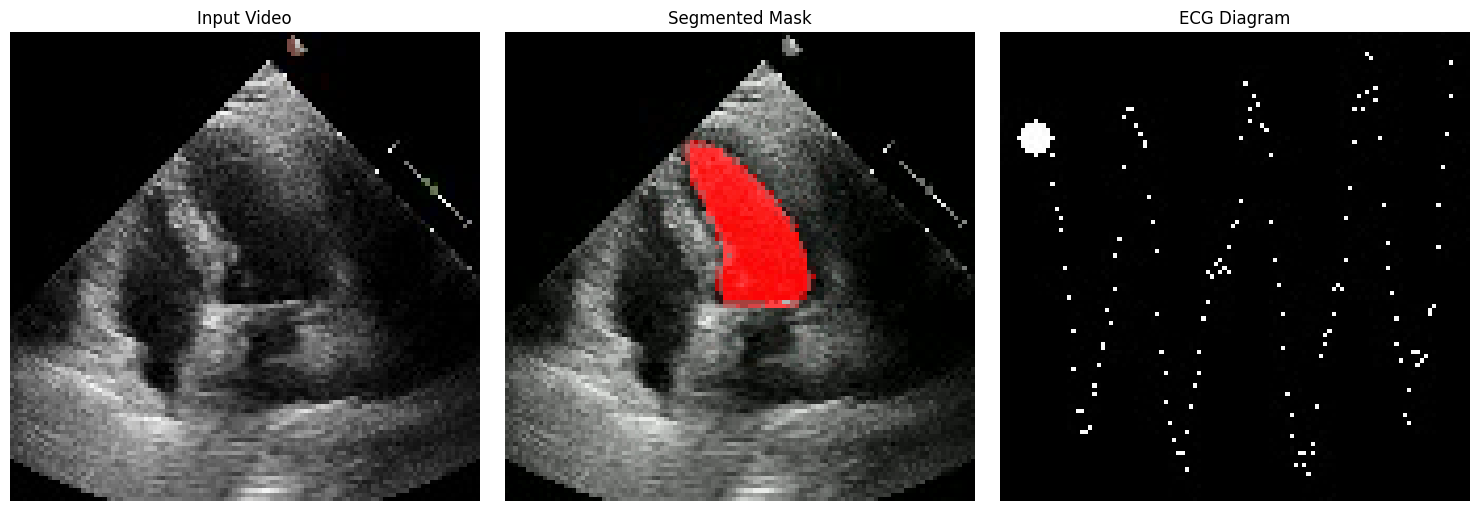

In [40]:
import matplotlib.pyplot as plt
from IPython.display import Image

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display each GIF in one of the columns
axes[0].imshow(plt.imread('/content/input_folder/input.gif'))
axes[0].axis('off')  # Hide axis
axes[0].set_title("Input Video")

axes[1].imshow(plt.imread('/content/input_folder/mask.gif'))
axes[1].axis('off')  # Hide axis
axes[1].set_title("Segmented Mask")

axes[2].imshow(plt.imread('/content/input_folder/ecg.gif'))
axes[2].axis('off')  # Hide axis
axes[2].set_title("ECG Diagram")

plt.tight_layout()  # Adjust layout
plt.show()


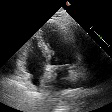

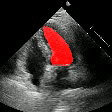

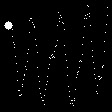

In [44]:
display(Image(filename='/content/input_folder/input.gif'))
display(Image(filename='/content/input_folder/mask.gif'))
display(Image(filename='/content/input_folder/ecg.gif'))